# **⚡ ASA Previous**

Iter   1000 | Temp 9.00000 | Avg Step 0.04500 | Best Energy 5581.50685
Iter   2000 | Temp 8.10000 | Avg Step 0.04050 | Best Energy -54.02456
Iter   3000 | Temp 7.29000 | Avg Step 0.03645 | Best Energy -57.33446
Iter   4000 | Temp 6.56100 | Avg Step 0.03281 | Best Energy -57.84145
Iter   5000 | Temp 5.90490 | Avg Step 0.02952 | Best Energy -59.45891
Iter   6000 | Temp 5.31441 | Avg Step 0.02657 | Best Energy -60.10163
Iter   7000 | Temp 4.78297 | Avg Step 0.02391 | Best Energy -61.48521
Iter   8000 | Temp 4.30467 | Avg Step 0.02152 | Best Energy -62.39429
Iter   9000 | Temp 3.87420 | Avg Step 0.01937 | Best Energy -62.52291
Iter  10000 | Temp 3.48678 | Avg Step 0.01743 | Best Energy -63.25227
Iter  11000 | Temp 3.13811 | Avg Step 0.01569 | Best Energy -63.56050
Iter  12000 | Temp 2.82430 | Avg Step 0.01412 | Best Energy -65.39104
Iter  13000 | Temp 2.54187 | Avg Step 0.01271 | Best Energy -66.05283
Iter  14000 | Temp 2.28768 | Avg Step 0.01144 | Best Energy -66.96285
Iter  15000 | Temp 

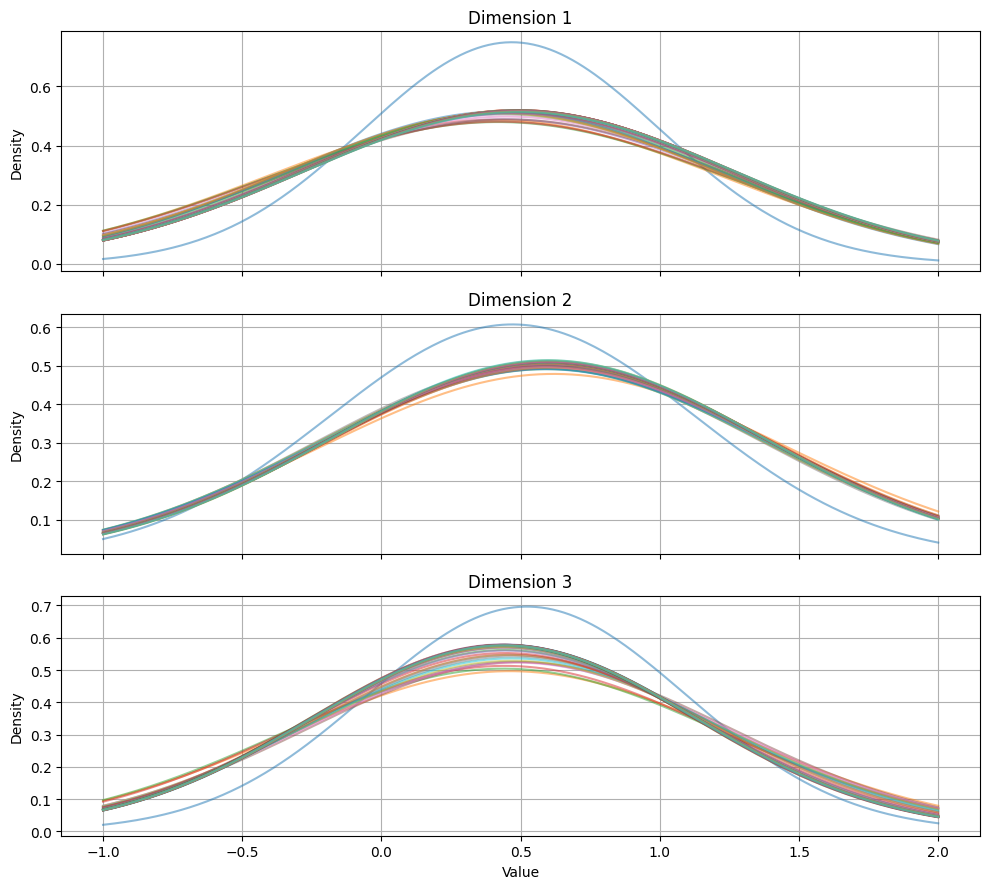

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def intermolecular_pair_potential(coordinates, epsilon=1.0, sigma=1.0):
    total_energy = 0.0
    n = len(coordinates)
    for i in range(n - 1):
        for j in range(i + 1, n):
            r = np.linalg.norm(coordinates[i] - coordinates[j])
            if r == 0:
                continue
            total_energy += 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)
    return total_energy

def adaptive_simulated_annealing_per_dimension(initial_coords, epsilon=1.0, sigma=1.0,
                                               initial_step=0.05, initial_temp=10, max_iter_factor=2000):
    n_particles, dims = initial_coords.shape
    max_iterations = max_iter_factor * n_particles

    coords = initial_coords.copy()
    current_energy = intermolecular_pair_potential(coords, epsilon, sigma)
    best_coords = coords.copy()
    best_energy = current_energy

    T = initial_temp
    step_matrix = np.full(coords.shape, initial_step)
    accept_matrix = np.zeros_like(coords)

    adapt_interval = 1000
    step_history = []
    energy_history = [current_energy]
    gaussian_snapshots = []

    for iteration in range(1, max_iterations + 1):
        noise = np.random.normal(loc=0.0, scale=step_matrix)
        proposal = coords + noise
        proposal_energy = intermolecular_pair_potential(proposal, epsilon, sigma)

        if proposal_energy < current_energy:
            coords = proposal
            current_energy = proposal_energy
            accept_matrix += 1

            if current_energy < best_energy:
                best_energy = current_energy
                best_coords = coords.copy()

        if iteration % adapt_interval == 0:
            acceptance_rate = accept_matrix / adapt_interval

            step_matrix[acceptance_rate < 0.2] *= 0.9
            step_matrix[acceptance_rate > 0.5] *= 1.1

            T *= 0.9
            accept_matrix.fill(0)

            avg_step = np.mean(step_matrix)
            step_history.append((iteration, avg_step))
            print(f"Iter {iteration:6d} | Temp {T:.5f} | Avg Step {avg_step:.5f} | Best Energy {best_energy:.5f}")

            # Capture Gaussian snapshot
            snapshot = []
            for dim in range(coords.shape[1]):
                mean = np.mean(coords[:, dim])
                std = np.std(coords[:, dim])
                snapshot.append((mean, std))
            gaussian_snapshots.append((iteration, snapshot))

        energy_history.append(current_energy)

        if np.mean(step_matrix) < 1e-5:
            print("Step sizes too small, stopping.")
            break

    print(f"Best energy found: {best_energy:.5f}")

    # Plot shifting Gaussians over iterations
    x = np.linspace(-1, 2, 300)
    fig, axs = plt.subplots(dims, 1, figsize=(10, 3 * dims), sharex=True)

    if dims == 1:
        axs = [axs]  # Ensure it's iterable

    for dim in range(dims):
        for iter_num, snapshot in gaussian_snapshots:
            mean, std = snapshot[dim]
            y = norm.pdf(x, mean, std)
            axs[dim].plot(x, y, alpha=0.5, label=f'Iter {iter_num}')
        axs[dim].set_title(f'Dimension {dim+1}')
        axs[dim].set_ylabel('Density')
        axs[dim].grid(True)

    axs[-1].set_xlabel('Value')
    plt.tight_layout()
    plt.show()

    return best_coords, best_energy

# Example usage
initial_coords = np.random.rand(20, 3)
optimized_coords, final_energy = adaptive_simulated_annealing_per_dimension(initial_coords)
